<a href="https://colab.research.google.com/github/tinayiluo0322/Computer-Engineering-Machine-Learning-and-Deep-Neural-Nets-Projects/blob/main/Construct_Train_Optimize_CNN_Models/simplenn_cifar10_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing SimpleNN on CIFAR-10

#### Luopeiwen Yi


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import os

In [3]:
# Change this to the absolute path where dataset.py and utils.py are stored
CODE_PATH = "/content/drive/MyDrive/CNN_hw"

# Add this path to sys.path so Python can find it
sys.path.append(CODE_PATH)

# Check if Colab can see the files
print("Files in directory:", os.listdir(CODE_PATH))

Files in directory: ['sample_predictions.csv', 'save_test_predictions.ipynb', '__pycache__', 'tools', 'simplenn-cifar10.ipynb']


# Optimization 4: Hyperparameter Tuning

## Step 1: Build the model


In [4]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
# Define SimpleNN with batch normalization
class SimpleNN_BN(nn.Module):
    def __init__(self):
        super(SimpleNN_BN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)  # BN Layer after conv1
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)  # BN Layer after conv2
        self.fc1   = nn.Linear(16 * 6 * 6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))  # Apply BN before activation
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

### Sanity Check

In [6]:
# Define the SimpleNN model
model = SimpleNN_BN()

# Create a dummy input tensor with the same shape as CIFAR-10 images (batch_size=1, channels=3, height=32, width=32)
dummy_input = torch.randn(1, 3, 32, 32)  # Shape: (1, 3, 32, 32)

# Pass the dummy input through the model
output = model(dummy_input)

# Check the output shape
print(f"Output shape: {output.shape}")  # Should be (1, 10) since we have 10 classes

# Count total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Output shape: torch.Size([1, 10])
Total number of parameters: 82078


In [7]:
from torchsummary import summary

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the SimpleNN model and move it to the selected device
model = SimpleNN_BN().to(device)

# Create a dummy input tensor and move it to the same device as the model
dummy_input = torch.randn(1, 3, 32, 32).to(device)  # Ensure input is on the same device

# Pass the dummy input through the model
output = model(dummy_input)

# Check the output shape
print(f"Output shape: {output.shape}")  # Should be (1, 10) since we have 10 classes

# Count total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

# Print model summary (Ensure model is on the correct device)
summary(model, (3, 32, 32), device=device.type)  # Specify the device

Using device: cuda
Output shape: torch.Size([1, 10])
Total number of parameters: 82078
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             608
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3           [-1, 16, 12, 12]           1,168
       BatchNorm2d-4           [-1, 16, 12, 12]              32
            Linear-5                  [-1, 120]          69,240
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 82,078
Trainable params: 82,078
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.13
Params size (MB): 0.31
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


## Step 1: Set up preprocessing functions


In [8]:
import torchvision.transforms as transforms

# Data augmentation for training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random cropping
    transforms.RandomHorizontalFlip(),  # Random flipping
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))  # Normalize
])

# No data augmentation for validation set
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

ToTensor(): Converts PIL images to PyTorch tensors so they can be used in deep learning models.

Normalize(mean, std): Standardizes pixel values to a mean of (0.4914, 0.4822, 0.4465) and std of (0.2023, 0.1994, 0.2010), helping the model converge faster.


## Step 2: Set up dataset and dataloader


In [9]:
# Do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# A few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

# Construct dataset
train_set = CIFAR10(
    root=DATA_ROOT,
    mode='train',
    download=True,
    transform=transform_train  # Apply training preprocessing
)

val_set = CIFAR10(
    root=DATA_ROOT,
    mode='val',
    download=True,
    transform=transform_val  # Apply validation preprocessing
)

# Construct dataloaders
train_loader = DataLoader(
    train_set,
    batch_size=TRAIN_BATCH_SIZE,  # Use predefined batch size
    shuffle=True,  # Shuffle training data for randomness
    num_workers=4  # Speed up data loading
)

val_loader = DataLoader(
    val_set,
    batch_size=VAL_BATCH_SIZE,  # Use predefined batch size
    shuffle=False,  # No need to shuffle validation data
    num_workers=4
)

# Sanity Check: Print dataset sizes
print(f"Train dataset size: {len(train_set)} images")
print(f"Validation dataset size: {len(val_set)} images")

# Check a single batch
sample_batch, sample_labels = next(iter(train_loader))
print(f"Sample batch shape: {sample_batch.shape}, Labels shape: {sample_labels.shape}")


141746176it [00:02, 54298649.23it/s]                                


Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Train dataset size: 45000 images
Validation dataset size: 5000 images
Sample batch shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128])


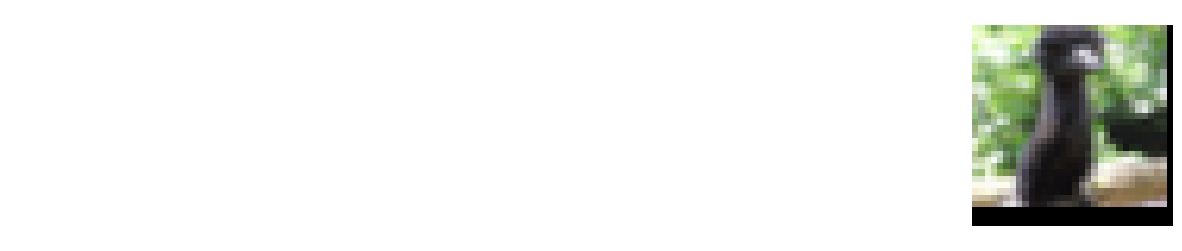

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Load one batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Function to unnormalize and display images
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert to HWC format
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = img * std + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)

# Plot some augmented images
fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i in range(5):
    imshow(images[i])
    axes[i].axis('off')
plt.show()

## Step 4: Set up the loss function and optimizer
Loss function/objective function is used to provide "feedback" for the neural networks. Typically, we use multi-class cross-entropy as the loss function for classification models. As for the optimizer, we will use SGD with momentum.

In [11]:
import torch.nn as nn
import torch.optim as optim

# Hyperparameters (Do NOT change)
INITIAL_LR = 0.01  # Initial learning rate
MOMENTUM = 0.9  # Momentum for optimizer
REG = 1e-4  # L2 regularization (weight decay)

# Create loss function (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

# Add optimizer (SGD with Momentum and L2 Regularization)
optimizer = optim.SGD(
    model.parameters(),  # Optimizing model parameters
    lr=INITIAL_LR,  # Learning rate
    momentum=MOMENTUM,  # Momentum factor
    weight_decay=REG  # L2 regularization
)

# Sanity check: Print optimizer details
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)


## Step 5: Start the training process.



In [12]:
import torch
import os

def train_model(model, optimizer, filename, epochs=30):
    """ Train the model and save the best checkpoint """

    CHECKPOINT_FOLDER = "./saved_model_dev"
    best_val_acc = 0

    # Ensure model is on the correct device
    model.to(device)

    model.eval()  # Set model to evaluation mode
    initial_loss = 0
    total_examples = 0
    correct_examples = 0

    with torch.no_grad():  # No gradient calculation
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Copy inputs and targets to the device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass: compute the output
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)
            initial_loss += loss.item()

            # Compute accuracy before training
            _, predicted = torch.max(outputs, 1)
            correct_examples += (predicted == targets).sum().item()
            total_examples += targets.size(0)

            # Only calculate on a small subset (e.g., 1 batch)
            if batch_idx == 0:
                break

    # Compute initial average loss and accuracy
    initial_loss /= (batch_idx + 1)
    initial_acc = correct_examples / total_examples
    print(f"Initial loss before training: {initial_loss:.4f}, Initial accuracy: {initial_acc:.4f}")


    print(f"==> Training {filename} model")
    print("=" * 50)

    for i in range(epochs):
        model.train()  # Set model to training mode
        print(f"Epoch {i}:")

        total_examples = 0
        correct_examples = 0
        train_loss = 0

        # Train loop
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Zero gradients & backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_examples += (predicted == targets).sum().item()
            total_examples += targets.size(0)

        avg_loss = train_loss / len(train_loader)
        avg_acc = correct_examples / total_examples
        print(f"Training loss: {avg_loss:.4f}, Training accuracy: {avg_acc:.4f}")

        # Validation loop
        model.eval()
        total_examples = 0
        correct_examples = 0
        val_loss = 0

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_examples += (predicted == targets).sum().item()
                total_examples += targets.size(0)

        avg_loss = val_loss / len(val_loader)
        avg_acc = correct_examples / total_examples
        print(f"Validation loss: {avg_loss:.4f}, Validation accuracy: {avg_acc:.4f}")

        # Save best model
        if avg_acc > best_val_acc:
            best_val_acc = avg_acc
            if not os.path.exists(CHECKPOINT_FOLDER):
                os.makedirs(CHECKPOINT_FOLDER)
            print(f"Saving best model for {filename}...")
            torch.save({'state_dict': model.state_dict()}, os.path.join(CHECKPOINT_FOLDER, filename))

        print('')

    print("=" * 50)
    print(f"==> Training finished for {filename}! Best validation accuracy: {best_val_acc:.4f}")

### Model Comparison

##### Learning Rate Tuning

In [13]:
# Define learning rates to test
learning_rates = [1.0, 0.1, 0.05, 0.01, 0.005, 0.001]

# Loop through different learning rates and train the model
for lr in learning_rates:
    print(f"\n=== Training with Learning Rate: {lr} ===")

    # Reinitialize the model
    model = SimpleNN_BN().to(device)

    # Create optimizer with the current learning rate
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

    # Train the model and save results
    filename = f"model_bn_lr_{lr}.pth"
    train_model(model, optimizer, filename)


=== Training with Learning Rate: 1.0 ===
Initial loss before training: 2.2913, Initial accuracy: 0.1406
==> Training model_bn_lr_1.0.pth model
Epoch 0:
Training loss: 2.3255, Training accuracy: 0.1060
Validation loss: 2.3302, Validation accuracy: 0.0978
Saving best model for model_bn_lr_1.0.pth...

Epoch 1:
Training loss: 2.3236, Training accuracy: 0.1010
Validation loss: 2.3270, Validation accuracy: 0.1028
Saving best model for model_bn_lr_1.0.pth...

Epoch 2:
Training loss: 2.3217, Training accuracy: 0.0989
Validation loss: 2.3316, Validation accuracy: 0.0980

Epoch 3:
Training loss: 2.3202, Training accuracy: 0.0993
Validation loss: 2.3186, Validation accuracy: 0.1054
Saving best model for model_bn_lr_1.0.pth...

Epoch 4:
Training loss: 2.3226, Training accuracy: 0.1000
Validation loss: 2.3192, Validation accuracy: 0.1016

Epoch 5:
Training loss: 2.3211, Training accuracy: 0.1004
Validation loss: 2.3127, Validation accuracy: 0.0986

Epoch 6:
Training loss: 2.3216, Training accuracy

- Not necessarily a very large learning rate beneficial for model training, and not necessarily a very small one either.  

- It's important the find the right one through searching the scope for hyperparameter tuning.

l2 strength tuning

In [14]:
# Define L2 regularization strengths to test
l2_strengths = [1e-2, 1e-3, 1e-4, 1e-5, 0.0]

# Loop through different L2 regularization strengths and train the model
for reg in l2_strengths:
    print(f"\n=== Training with L2 Regularization Strength: {reg} ===")

    # Reinitialize the model
    model = SimpleNN_BN().to(device)

    # Create optimizer with the current L2 regularization strength
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=reg)

    # Train the model and save results
    filename = f"model_bn_l2_{reg}.pth"
    train_model(model, optimizer, filename)


=== Training with L2 Regularization Strength: 0.01 ===
Initial loss before training: 2.3073, Initial accuracy: 0.0859
==> Training model_bn_l2_0.01.pth model
Epoch 0:
Training loss: 1.7755, Training accuracy: 0.3330
Validation loss: 1.5533, Validation accuracy: 0.4338
Saving best model for model_bn_l2_0.01.pth...

Epoch 1:
Training loss: 1.5059, Training accuracy: 0.4450
Validation loss: 1.4191, Validation accuracy: 0.4734
Saving best model for model_bn_l2_0.01.pth...

Epoch 2:
Training loss: 1.4093, Training accuracy: 0.4821
Validation loss: 1.3209, Validation accuracy: 0.5126
Saving best model for model_bn_l2_0.01.pth...

Epoch 3:
Training loss: 1.3583, Training accuracy: 0.5067
Validation loss: 1.2826, Validation accuracy: 0.5380
Saving best model for model_bn_l2_0.01.pth...

Epoch 4:
Training loss: 1.3316, Training accuracy: 0.5191
Validation loss: 1.2827, Validation accuracy: 0.5302

Epoch 5:
Training loss: 1.3083, Training accuracy: 0.5291
Validation loss: 1.3313, Validation acc

Interesting result. Seems like we don't need l2 regularization at all for good validation accuracy performance. The less regularization the better the performance in general.

l1 strength VS l2 strength

In [15]:
# Define L1 regularization strength
L1_LAMBDA = 1e-3  # You can tune this value

# Define a new train model with l1 regularization option
def train_model(model, optimizer, filename, epochs=30, use_l1=False):
    """ Train the model and save the best checkpoint """

    CHECKPOINT_FOLDER = "./saved_model_dev"
    best_val_acc = 0

    # Ensure model is on the correct device
    model.to(device)

    # Initial evaluation before training
    model.eval()  # Set model to evaluation mode
    initial_loss = 0
    total_examples = 0
    correct_examples = 0

    with torch.no_grad():  # No gradient calculation
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Copy inputs and targets to the device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass: compute the output
            outputs = model(inputs)

            # Compute standard loss
            loss = criterion(outputs, targets)

            # Add L1 regularization (if enabled)
            if use_l1:
                l1_loss = sum(torch.abs(p).sum() for p in model.parameters())
                loss += L1_LAMBDA * l1_loss

            initial_loss += loss.item()

            # Compute accuracy before training
            _, predicted = torch.max(outputs, 1)
            correct_examples += (predicted == targets).sum().item()
            total_examples += targets.size(0)

            # Only calculate on a small subset (e.g., 1 batch)
            if batch_idx == 0:
                break

    # Compute initial average loss and accuracy
    initial_loss /= (batch_idx + 1)
    initial_acc = correct_examples / total_examples
    print(f"Initial loss before training: {initial_loss:.4f}, Initial accuracy: {initial_acc:.4f}")

    print(f"==> Training {filename} model")
    print("=" * 50)

    for i in range(epochs):
        model.train()  # Set model to training mode
        print(f"Epoch {i+1}/{epochs}:")

        total_examples = 0
        correct_examples = 0
        train_loss = 0

        # Train loop
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Add L1 regularization if enabled
            if use_l1:
                l1_loss = sum(torch.abs(p).sum() for p in model.parameters())
                loss += L1_LAMBDA * l1_loss

            # Zero gradients & backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_examples += (predicted == targets).sum().item()
            total_examples += targets.size(0)

        avg_loss = train_loss / len(train_loader)
        avg_acc = correct_examples / total_examples
        print(f"Training loss: {avg_loss:.4f}, Training accuracy: {avg_acc:.4f}")

        # Validation loop
        model.eval()
        total_examples = 0
        correct_examples = 0
        val_loss = 0

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Add L1 regularization if enabled
                if use_l1:
                    l1_loss = sum(torch.abs(p).sum() for p in model.parameters())
                    loss += L1_LAMBDA * l1_loss

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_examples += (predicted == targets).sum().item()
                total_examples += targets.size(0)

        avg_loss = val_loss / len(val_loader)
        avg_acc = correct_examples / total_examples
        print(f"Validation loss: {avg_loss:.4f}, Validation accuracy: {avg_acc:.4f}")

        # Save best model
        if avg_acc > best_val_acc:
            best_val_acc = avg_acc
            if not os.path.exists(CHECKPOINT_FOLDER):
                os.makedirs(CHECKPOINT_FOLDER)
            print(f"Saving best model for {filename}...")
            torch.save({'state_dict': model.state_dict()}, os.path.join(CHECKPOINT_FOLDER, filename))

        print('')

    print("=" * 50)
    print(f"==> Training finished for {filename}! Best validation accuracy: {best_val_acc:.4f}")

In [16]:
# Train the model with L1 Regularization
model_l1 = SimpleNN_BN().to(device)
optimizer_l1 = torch.optim.SGD(model_l1.parameters(), lr=0.01, momentum=0.9)  # No weight_decay (L2 off)
train_model(model_l1, optimizer_l1, "model_bn_l1.pth", use_l1=True)  # Enable L1 Regularization

Initial loss before training: 4.3993, Initial accuracy: 0.0938
==> Training model_bn_l1.pth model
Epoch 1/30:
Training loss: 2.9918, Training accuracy: 0.3233
Validation loss: 2.1014, Validation accuracy: 0.4314
Saving best model for model_bn_l1.pth...

Epoch 2/30:
Training loss: 1.9935, Training accuracy: 0.4270
Validation loss: 1.7865, Validation accuracy: 0.4696
Saving best model for model_bn_l1.pth...

Epoch 3/30:
Training loss: 1.7832, Training accuracy: 0.4674
Validation loss: 1.6690, Validation accuracy: 0.5076
Saving best model for model_bn_l1.pth...

Epoch 4/30:
Training loss: 1.7084, Training accuracy: 0.4879
Validation loss: 1.6033, Validation accuracy: 0.5220
Saving best model for model_bn_l1.pth...

Epoch 5/30:
Training loss: 1.6625, Training accuracy: 0.5054
Validation loss: 1.5266, Validation accuracy: 0.5460
Saving best model for model_bn_l1.pth...

Epoch 6/30:
Training loss: 1.6465, Training accuracy: 0.5123
Validation loss: 1.5462, Validation accuracy: 0.5468
Saving b

In [17]:
# Train the model with L2 Regularization
model_l2 = SimpleNN_BN().to(device)
optimizer_l2 = torch.optim.SGD(model_l2.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)  # L2 Regularization
train_model(model_l2, optimizer_l2, "model_bn_l2.pth", use_l1=False)  # Default = No L1

Initial loss before training: 2.3106, Initial accuracy: 0.0469
==> Training model_bn_l2.pth model
Epoch 1/30:
Training loss: 1.7797, Training accuracy: 0.3338
Validation loss: 1.5139, Validation accuracy: 0.4328
Saving best model for model_bn_l2.pth...

Epoch 2/30:
Training loss: 1.4730, Training accuracy: 0.4602
Validation loss: 1.3277, Validation accuracy: 0.5192
Saving best model for model_bn_l2.pth...

Epoch 3/30:
Training loss: 1.3583, Training accuracy: 0.5084
Validation loss: 1.2103, Validation accuracy: 0.5668
Saving best model for model_bn_l2.pth...

Epoch 4/30:
Training loss: 1.2766, Training accuracy: 0.5409
Validation loss: 1.1842, Validation accuracy: 0.5742
Saving best model for model_bn_l2.pth...

Epoch 5/30:
Training loss: 1.2118, Training accuracy: 0.5646
Validation loss: 1.1033, Validation accuracy: 0.6066
Saving best model for model_bn_l2.pth...

Epoch 6/30:
Training loss: 1.1625, Training accuracy: 0.5838
Validation loss: 1.0616, Validation accuracy: 0.6258
Saving b

In [18]:
# Function to extract and flatten model weights
def get_model_weights(model):
    weights = []
    for param in model.parameters():
        if param.requires_grad:  # Only trainable parameters
            weights.append(param.detach().cpu().numpy().flatten())  # Flatten each weight matrix
    return np.concatenate(weights)

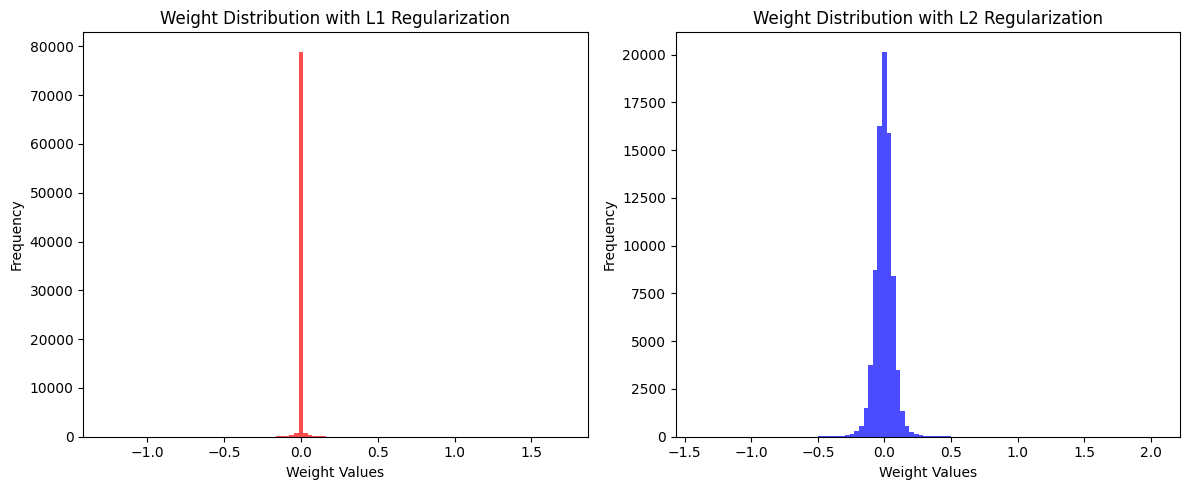

In [19]:
# Extract weights
weights_l1 = get_model_weights(model_l1)
weights_l2 = get_model_weights(model_l2)

# Plot weight distributions
plt.figure(figsize=(12, 5))

# L1 Regularization Histogram
plt.subplot(1, 2, 1)
plt.hist(weights_l1, bins=100, alpha=0.7, color='red')
plt.title("Weight Distribution with L1 Regularization")
plt.xlabel("Weight Values")
plt.ylabel("Frequency")

# L2 Regularization Histogram
plt.subplot(1, 2, 2)
plt.hist(weights_l2, bins=100, alpha=0.7, color='blue')
plt.title("Weight Distribution with L2 Regularization")
plt.xlabel("Weight Values")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

- best validation accuracy for model with l1 penalty: 60.54%
- best validation accuracy for model with l2 penalty: 70.84%

Most weights is set to 0 for l1 regularization, promotes sparsity.
Most weights are close to 0 for l2 regularization as it results in smaller weights but does not set them to 0.